In [1]:
!pip install cmake opencv-python
!conda install -y dlib

  Using cached cmake-4.2.1-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (6.5 kB)
  Using cached opencv_python-4.13.0.92-cp37-abi3-manylinux_2_28_x86_64.whl.metadata (19 kB)
Using cached cmake-4.2.1-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (28.9 MB)
Using cached opencv_python-4.13.0.92-cp37-abi3-manylinux_2_28_x86_64.whl (72.9 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [cmake]32m1/2 [cmake]
Channels:
 - conda-forge
Platform: linux-64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 25.5.1
    latest version: 26.1.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - dlib


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2026.1.4   |       hbd8a1cb_0         143 KB

In [2]:
import cv2
import dlib

print(cv2.__version__)
print(dlib.__version__)

4.13.0
20.0.0


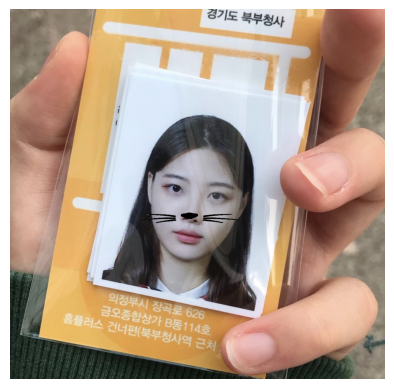

True

In [19]:
import os
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt

img_path = "selfie.jpg"
sticker_path = "decoration.png"

img_bgr = cv2.imread(img_path)

img_show = img_bgr.copy()
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

detector = dlib.get_frontal_face_detector()

home_dir = os.getenv("HOME")
model_path = os.path.join(home_dir, "work/camera_sticker/models/shape_predictor_68_face_landmarks.dat")
predictor = dlib.shape_predictor(model_path)

rects = detector(img_rgb, 1)

rect = rects[0]
shape = predictor(img_rgb, rect)
landmarks = [(p.x, p.y) for p in shape.parts()]

# 스티커 위치 기준점(코끝) + 높이 오프셋
# 30: 코대 / 33: 코끝(추천) / 51: 윗입술 중앙
nose_x, nose_y = landmarks[33]  # 코끝으로 기준 변경

# 높이 미세 조정값 (값이 커질수록 아래로 내려감)
y_offset = -88

# 스티커 크기
face_w = rect.width()
sticker_h = int(face_w * 0.45)

# 스티커 로드 / 리사이즈
sticker = cv2.imread(sticker_path)
sticker = cv2.resize(sticker, (face_w, sticker_h))

# 스티커 부착 좌표
rx = nose_x - face_w // 2
ry = nose_y + y_offset

# 이미지 밖으로 나가면 crop(경계 보정)
if rx < 0:
    sticker = sticker[:, -rx:]
    rx = 0
if ry < 0:
    sticker = sticker[-ry:, :]
    ry = 0
if rx + sticker.shape[1] > img_show.shape[1]:
    sticker = sticker[:, :img_show.shape[1] - rx]
if ry + sticker.shape[0] > img_show.shape[0]:
    sticker = sticker[:img_show.shape[0] - ry, :]

# 합성할 ROI
roi = img_show[ry:ry + sticker.shape[0], rx:rx + sticker.shape[1]]

# 흰 배경 제거(화이트 박스 제거) 후 합성
sticker_gray = cv2.cvtColor(sticker, cv2.COLOR_BGR2GRAY)
bg_mask = (sticker_gray > 240)                 # True = 흰 배경
bg_mask_3 = np.stack([bg_mask]*3, axis=2)      # (H,W) -> (H,W,3)

img_show[ry:ry + sticker.shape[0], rx:rx + sticker.shape[1]] = \
    np.where(bg_mask_3, roi, sticker).astype(np.uint8)

# 출력
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

cv2.imwrite("selfie_with_decoration.png", img_show)